## OFS via Sparse Projection

As given by Online Feature Selection and its Applications.

- shouldn't the threshold within the training function be zero not one?
- the original code wasn't available anymore
  - neither here https://www.stevenhoi.com/publications
  - or here http://OFS.stevenhoi.org/
- found implementations:
  - matlap: https://github.com/Isilendil/OFS
  - java: https://github.com/mbdemoraes/moafs


In [2]:
# normalize data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

df = pd.read_csv("datasets/binary/shuffle_spambase.csv")
df_class_col = df['class']
df_class_col

df_scaled = pd.DataFrame(sc.fit_transform(df))
df_scaled.columns = df.columns

df_scaled['class'] = df_class_col
df_scaled.head()
df_scaled.to_csv("datasets/binary/shuffle_spambase_normalized.csv", index=False)

In [1]:
# ofs via sparse projection
import numpy as np

class OFS:
    def __init__(self, regularization_param, step_size, n_selected_ftr, n_total_ftr):
        self.regularization_param = regularization_param
        self.step_size = step_size
        self.n_selected_ftr = n_selected_ftr
        self.w = np.zeros(n_total_ftr)
    

    def train(self, x, y):
        if y == 0:
            y = -1

        if np.dot(x, self.w) * y <= 1: # should be 0, shouldn't it
            w_tilde = (1-self.regularization_param * self.step_size)*self.w + self.step_size * y * x
            w_hat = min(1, (1/np.sqrt(self.regularization_param)) / np.linalg.norm(w_tilde) )*w_tilde
            self.w = self.__truncate(w_hat, self.n_selected_ftr)
        else:
            self.w *= (1-self.regularization_param*self.step_size)

    def __truncate(self, weights_array, B):
        w = np.zeros(len(weights_array))
        indices = np.argsort(weights_array)[::-1][:B-1]
        w[indices] = weights_array[indices]
        return w

    def get_feature_indices(self):
        return np.argsort(self.w)[::-1][:self.n_selected_ftr - 1]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


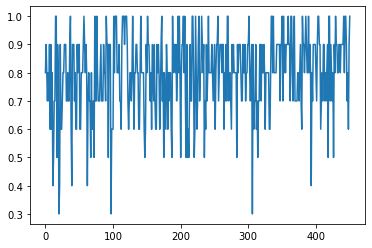

In [3]:
# use OFS
import numpy as np
from skmultiflow.data import FileStream
from skmultiflow.neural_networks import PerceptronMask
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

stream = FileStream('datasets/binary/shuffle_spambase_normalized.csv', target_idx=57)
stream.prepare_for_use()

x,y = stream.next_sample(batch_size=100)
predictor = PerceptronMask()
predictor.partial_fit(x,y, stream.target_values)

n_selected_ftr = 10

ofs = OFS(regularization_param = 0.01, step_size = 0.1, n_selected_ftr=n_selected_ftr, n_total_ftr=stream.n_num_features)

accuracy = []

while stream.has_more_samples():
    # Load a new sample
    x, y = stream.next_sample(batch_size=10)

    # Select features
    for idx, label in enumerate(y):
        ofs.train(x[idx],label)

    selected_ftr = ofs.get_feature_indices()
    # Truncate x (retain only selected features, 'remove' all others, e.g. by replacing them with 0)
    x_reduced = np.zeros(x.shape)
    x_reduced[:, selected_ftr] = x[:, selected_ftr]

    # Test
    y_pred = predictor.predict(x)
    accuracy.append(accuracy_score(y, y_pred))

    # Train
    predictor.partial_fit(x, y)


plt.plot(accuracy)
plt.show()
# Restart the FileStream
stream.restart()

In [25]:
stream.n_num_features

57

[0.9, 1.0]

### Multiclass Case
- more then one vector perceptron
- maybe build mean over all vectors befor truncation
